# Measure intensity vs. time in angular or concentric regions

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

import matplotlib
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

from microfilm.dataset import MultipageTIFF
import microfilm.microplot
from roidynamics import splitmask

## Define paths to image and roi

In [3]:
image_path = '../roidynamics/tests/test_folders/test_multipage_good/'
roi_path = '../roidynamics//tests/test_folders/test_multipage_good/roi.bmp'

## Import data

Here we use a ```MultipageTIFF``` dataset as defined in the ```from microfilm.dataset``` module. We can however exchange this for a tif series, h5 or Nikon ND2 file.

In [4]:
image = MultipageTIFF(image_path)
roi = skimage.io.imread(roi_path)

In [5]:
image.channel_name

['C1-MAX_mitosis.tif', 'C2-MAX_mitosis.tif']

## Measure the roi center of mass

In [6]:
cm = splitmask.get_roi_cm(roi_im=roi)

In [7]:
im_np = image.load_frame(channel_name=image.channel_name[1], frame=20)

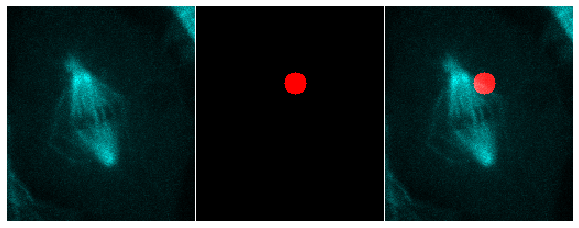

In [8]:
panel = microfilm.microplot.Micropanel(1,3, figscaling=3)
panel.add_element(pos = [0,0], microim=microfilm.microplot.Microimage(im_np, cmaps=['pure_cyan']))
panel.add_element(pos = [0,1], microim=microfilm.microplot.Microimage(roi))
panel.add_element(pos = [0,2], microim=microfilm.microplot.Microimage([im_np, roi],['pure_cyan', 'pure_red']))

## Radial sectors

Here we create a labelled image with sectors as concentric rings. We can define the width and the number of rings.

We also create a colormap which optimally scales for the number of regions generated. The color map can be used both to display the labelled image and for regular plots (see below).

In [9]:
sector_width = 5
num_sectors = 10

In [10]:
radius_labels = splitmask.create_concentric_mask(center=cm, im_dims=image.dims,
                                                         sector_width=sector_width, num_sectors=num_sectors)
colors_rad, cmap_rad = splitmask.get_cmap_labels(radius_labels, cmap_name='cool')

To plot both an image and the sectors overlay on top of it, we can use the ```plot_sectors``` function. It takes an ```ìmage``` ```Dataset```, a ```sectors``` mask and its corresponding colormap ```cmap``` and finally you can specify which ```channel``` of the ```Dataset``` to plot.

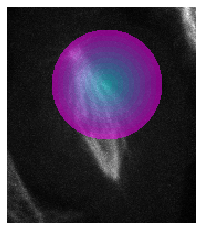

In [11]:
myplot = splitmask.plot_sectors(image=image, sectors=radius_labels, cmap=cmap_rad, channel=image.channel_name[1]);

To save the figure, just use:

In [12]:
myplot.savefig('mysectors.png')

### Changing the image colormap

You can also use the microfilm package to generate and use alternative colormaps for the image plot itself and pass it via the ```im_cmap``` parameter. For example if you want to have a gray-scale inverted colormap:

In [13]:
gray_invert = microfilm.colorify.cmaps_def('gray', flip_map=True)

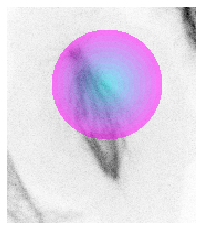

In [14]:
myplot = splitmask.plot_sectors(image, radius_labels, cmap=cmap_rad, im_cmap=gray_invert, channel=image.channel_name[1]);

## Angular sectors

Here we create a labelled image with sectors as "pie" parts of a disk. We can define the angular size of the parts and the radius of the disk. Again, we create an optimal color map.

In [15]:
angular_width = 20
max_rad =50
sector_labels = splitmask.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad)
colors_angle, cmap_angle = splitmask.get_cmap_labels(sector_labels, cmap_name='viridis')

To display the image and the sectors, you can use the ```plot_sectors``` function:

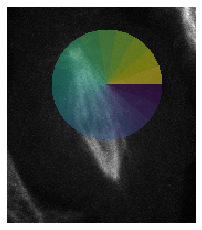

In [16]:
splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, channel=image.channel_name[1]);

## Angular and radial sectors

We can also combine the radial and angular masks, to create only a ring with a given width. For that we use again the ```create_sector_mask``` function but use **and additional parameter ```radius``` for the ring width**.

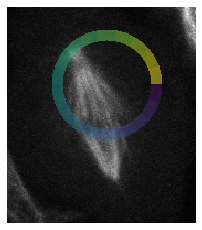

In [17]:
angular_width = 20
max_rad = 50
ring_width = 10
sector_labels = splitmask.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad, ring_width=ring_width)
colors_angle, cmap_angle = splitmask.get_cmap_labels(sector_labels, cmap_name='viridis')

splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, channel=image.channel_name[1]);

## Extracting signals

With the labelled image of sectors and the time-lapse data, we can now extract the intensity in each sector across time and plot it. If multiple channels are available in the dataset, we can change it.

In [18]:
channel = image.channel_name[1]

signal_radius = splitmask.measure_intensities(image, channels=channel, 
                                                      im_labels=radius_labels,max_time=51)
signal_angle = splitmask.measure_intensities(image, channels=channel, 
                                                     im_labels=sector_labels,max_time=51)


To plot the signals you can use the ```plot_signals``` function. You can pass the colormap array produced by the ```get_cmap_labels``` function to color the curves with the same colors as the corresponding sectors.


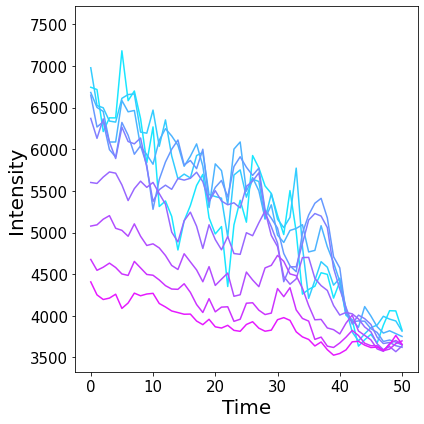

In [19]:
myplot = splitmask.plot_signals(signal_radius, color_array=colors_rad);

### Extracting signal from multiple channels

Instead of a single channel, you can also provide a list of channels from where to extract the signal:

In [20]:
channels = image.channel_name
channels

['C1-MAX_mitosis.tif', 'C2-MAX_mitosis.tif']

In [21]:
signal_radius_multi = splitmask.measure_intensities(
    image, channels=channels, 
    im_labels=radius_labels)

Now the output has an additional dimension corresponding to the number of channels, here 2. When using the ```plot_signals``` function, you can specify which channel (numerical index now) you want to plot:

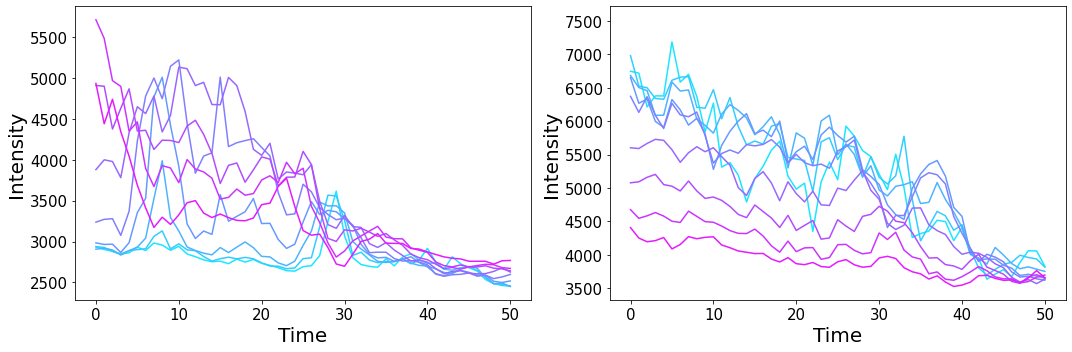

In [22]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
splitmask.plot_signals(signal_radius_multi, channel=0, color_array=colors_rad, ax=ax[0])
splitmask.plot_signals(signal_radius_multi, channel=1, color_array=colors_rad, ax=ax[1]);
                                  

### Limited time points

You can also limit your analyis to a given fraction of the time lapse using the ```max_time```, ```min_time``` and ```steps``` parameters:

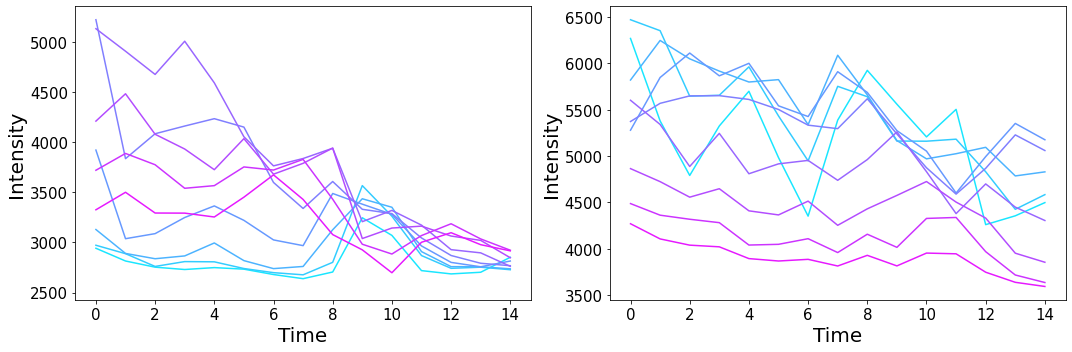

In [23]:
signal_radius_multi = splitmask.measure_intensities(
    image, channels=channels, 
    im_labels=radius_labels, min_time=10, max_time=40, step=2)

fig, ax = plt.subplots(1,2, figsize=(15,5))
splitmask.plot_signals(signal_radius_multi, channel=0, color_array=colors_rad, ax=ax[0])
splitmask.plot_signals(signal_radius_multi, channel=1, color_array=colors_rad, ax=ax[1]);    

Note that the time axis is not correct here and needs to be manually adjusted.

## Plotting

The plotting functions can optionally take an axis as argument to insert the plot in an existing figure:

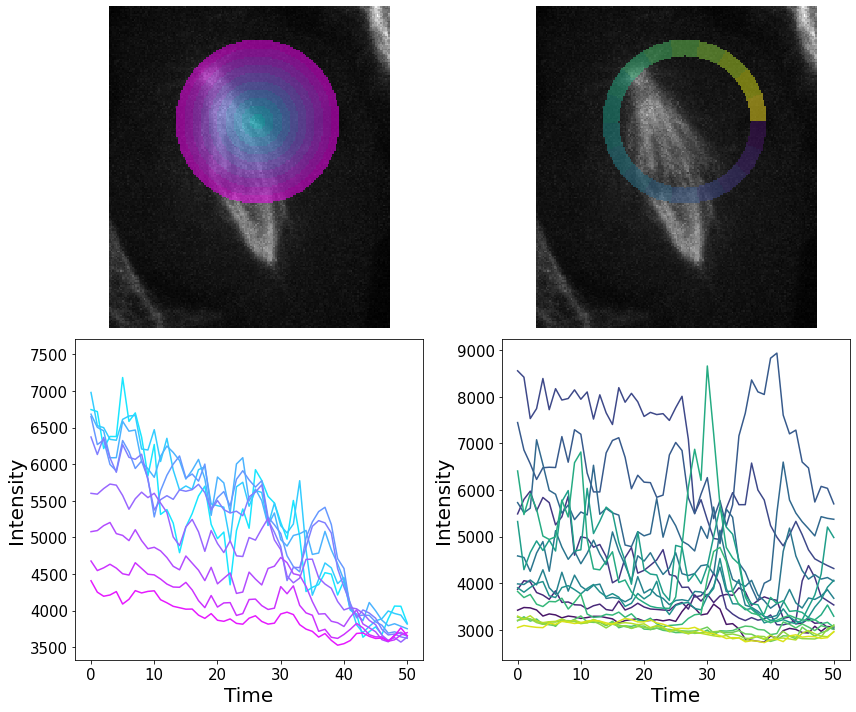

In [24]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

splitmask.plot_signals(signal_radius, channel=0, color_array=colors_rad, ax=ax[1,0]);
splitmask.plot_signals(signal_angle, channel=0, color_array=colors_angle, ax=ax[1,1]);

splitmask.plot_sectors(image, radius_labels, cmap=cmap_rad, ax=ax[0,0], channel=image.channel_name[1]);
splitmask.plot_sectors(image, sector_labels, cmap=cmap_angle, ax=ax[0,1], channel=image.channel_name[1]);
plt.tight_layout()

## Export

To save a simple plot you can use the Matplotlib ```savefig``` function with all its options. This works both for the image plots and the signal plots:

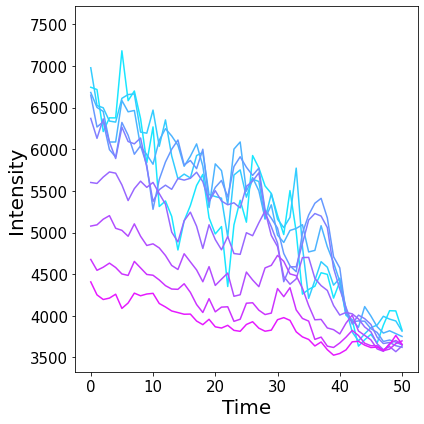

In [25]:
myplot = splitmask.plot_signals(signal_radius, color_array=colors_rad);

myplot.savefig('myplot.png')

To export the data as CSV file use the ```save_signal``` function:

In [26]:
splitmask.save_signal(signal=signal_radius, name='signal_radius.csv')

When saving data for multiple channels, an additional column is added in long format containing the channel name which has to be provided via the ```channels``` parameter:

In [27]:
splitmask.save_signal(signal=signal_radius_multi,
                                 name='signal_radius_multi.csv', channels=['ch1', 'ch2'])

To re-import the data you can just use the standard Pandas reader:

In [28]:
import pandas as pd
pd.read_csv('signal_radius_multi.csv')

,time,sector,channel,roi,intensity
0,0,0,ch1,0,2815.985507
1,0,0,ch2,0,5471.478261
2,0,1,ch1,0,2942.131356
3,0,1,ch2,0,6269.080508
4,0,2,ch1,0,2972.229592
...,...,...,...,...,...
295,14,7,ch2,0,3854.081911
296,14,8,ch1,0,2922.705090
297,14,8,ch2,0,3635.380240
298,14,9,ch1,0,2916.318428
